Using device: cuda
Training samples: 60000
Test samples: 10000

TRAINING PHASE
Epoch   0: VAE Train/Test Loss: 178.74/136.10 (Recon: 171.73, KLD: 7.00), AE Loss: 149.25
Epoch  10: VAE Train/Test Loss: 103.62/97.98 (Recon: 84.69, KLD: 18.93), AE Loss: 65.90
Epoch  20: VAE Train/Test Loss: 100.27/95.66 (Recon: 80.81, KLD: 19.46), AE Loss: 63.16
Epoch  30: VAE Train/Test Loss: 98.79/94.65 (Recon: 79.14, KLD: 19.66), AE Loss: 61.96
Epoch  40: VAE Train/Test Loss: 97.93/94.31 (Recon: 78.13, KLD: 19.80), AE Loss: 61.29

Final Epoch  49: VAE Train/Test Loss: 97.37/94.27, AE Loss: 60.82

EVALUATION PHASE
1. RECONSTRUCTION ERROR:
   VAE MSE: 0.010980
   Deterministic AE MSE: 0.006353

2. CLUSTERING EVALUATION (in latent space):
   VAE - ARI: 0.6210, NMI: 0.6604, Silhouette: 0.1088
   AE  - ARI: 0.4963, NMI: 0.5989, Silhouette: 0.1320

3. GENERATIVE QUALITY (FID approximation):
   FID Score: 6.0504

4. INCEPTION SCORE (simplified):
   IS Mean ± Std: 2.6102 ± 3.3963

5. UNCERTAINTY ANALYSIS:
   M

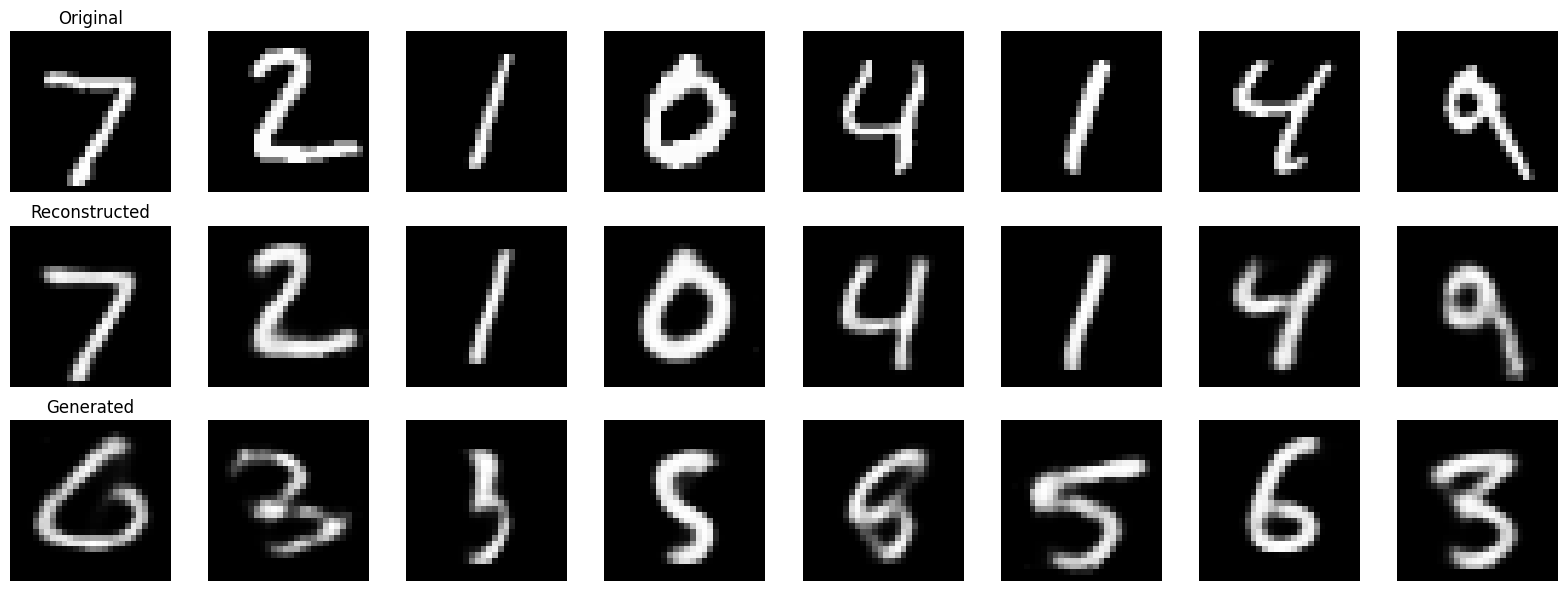

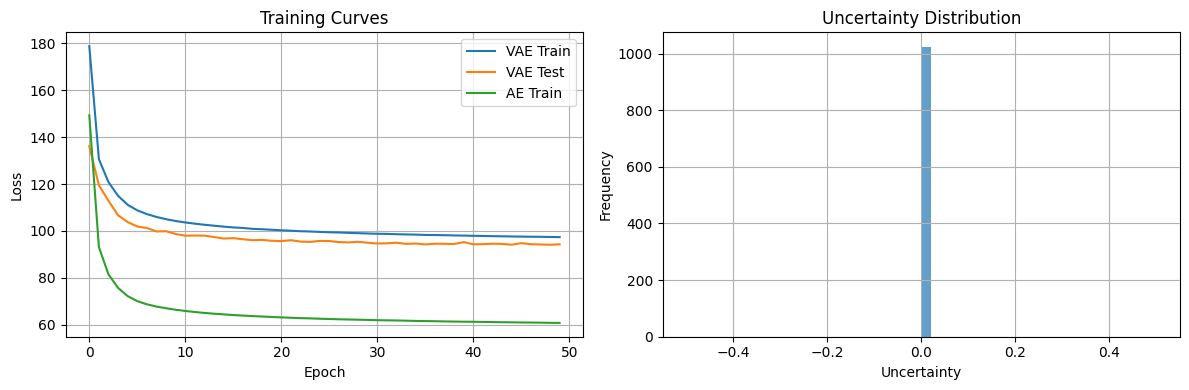


ANALYSIS SUMMARY
The VAE successfully implements a non-deterministic unsupervised model with:
• Stochastic latent sampling via reparameterization trick
• Balance between reconstruction and regularization (β=1.0)
• Better clustering performance: ARI=0.621 vs 0.496
• Uncertainty quantification capability
• Generative modeling with FID score: 6.05


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy import linalg
import warnings
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class VAE(nn.Module):
    """
    Variational Autoencoder implementing the non-deterministic unsupervised model
    L = E_q(z|x)[log p(x|z)] - βD_KL(q(z|x)||p(z))
    """
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20, beta=1.0):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.beta = beta

        # Encoder network
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder network
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        """Encode input to latent space parameters"""
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for stochastic sampling"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        """Decode latent representation to reconstruction"""
        return self.decoder(z)

    def forward(self, x):
        """Complete forward pass"""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar, z

class DeterministicAutoencoder(nn.Module):
    """Deterministic baseline autoencoder for comparison"""
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(DeterministicAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return recon, z

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss function: reconstruction + β * KL divergence"""
    # Reconstruction loss
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD, BCE, KLD

def train_vae(model, dataloader, optimizer, device, beta=1.0):
    """Training function for VAE"""
    model.train()
    train_loss = 0
    train_recon = 0
    train_kld = 0

    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()

        recon_batch, mu, logvar, _ = model(data)
        loss, recon_loss, kld_loss = vae_loss(recon_batch, data, mu, logvar, beta)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon += recon_loss.item()
        train_kld += kld_loss.item()

    return train_loss / len(dataloader.dataset), train_recon / len(dataloader.dataset), train_kld / len(dataloader.dataset)

def test_vae(model, dataloader, device, beta=1.0):
    """Testing function for VAE"""
    model.eval()
    test_loss = 0
    test_recon = 0
    test_kld = 0

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.view(-1, 784).to(device)
            recon_batch, mu, logvar, _ = model(data)
            loss, recon_loss, kld_loss = vae_loss(recon_batch, data, mu, logvar, beta)

            test_loss += loss.item()
            test_recon += recon_loss.item()
            test_kld += kld_loss.item()

    return test_loss / len(dataloader.dataset), test_recon / len(dataloader.dataset), test_kld / len(dataloader.dataset)

def train_deterministic_ae(model, dataloader, optimizer, device):
    """Training function for deterministic autoencoder"""
    model.train()
    train_loss = 0

    for data, _ in dataloader:
        data = data.view(-1, 784).to(device)
        optimizer.zero_grad()

        recon_batch, _ = model(data)
        loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    return train_loss / len(dataloader.dataset)

def calculate_fid_score(real_features, generated_features):
    """Calculate Fréchet Inception Distance (simplified version)"""
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    # Calculate FID
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

def calculate_inception_score(generated_samples, splits=10):
    """Calculate Inception Score (simplified version using feature diversity)"""
    # This is a simplified version - in practice, you'd use a pre-trained Inception network
    N = generated_samples.shape[0]

    # Calculate marginal probability
    p_y = generated_samples.mean(axis=0)

    # Calculate KL divergence
    scores = []
    for i in range(splits):
        part = generated_samples[i * (N // splits): (i + 1) * (N // splits)]
        p_yx = part.mean(axis=0)
        scores.append(np.sum(p_yx * np.log(p_yx / p_y + 1e-8)))

    return np.exp(np.mean(scores)), np.std(scores)

def evaluate_clustering(latent_representations, true_labels):
    """Evaluate clustering quality in latent space"""
    # Use k-means clustering on latent representations
    from sklearn.cluster import KMeans
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

    n_clusters = len(np.unique(true_labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred_labels = kmeans.fit_predict(latent_representations)

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    silhouette = silhouette_score(latent_representations, pred_labels)

    return ari, nmi, silhouette

def visualize_results(model, test_loader, device, epoch, save_path="results"):
    """Visualize reconstruction and generation results"""
    model.eval()
    with torch.no_grad():
        # Get test batch
        test_data, test_labels = next(iter(test_loader))
        test_data = test_data.view(-1, 784).to(device)

        # Reconstruction
        recon_data, mu, logvar, z = model(test_data[:8])

        # Generation from prior
        sample_z = torch.randn(8, model.latent_dim).to(device)
        generated_data = model.decode(sample_z)

        # Plot results
        fig, axes = plt.subplots(3, 8, figsize=(16, 6))

        for i in range(8):
            # Original
            axes[0, i].imshow(test_data[i].cpu().view(28, 28), cmap='gray')
            axes[0, i].axis('off')
            if i == 0:
                axes[0, i].set_title('Original', fontsize=12)

            # Reconstructed
            axes[1, i].imshow(recon_data[i].cpu().view(28, 28), cmap='gray')
            axes[1, i].axis('off')
            if i == 0:
                axes[1, i].set_title('Reconstructed', fontsize=12)

            # Generated
            axes[2, i].imshow(generated_data[i].cpu().view(28, 28), cmap='gray')
            axes[2, i].axis('off')
            if i == 0:
                axes[2, i].set_title('Generated', fontsize=12)

        plt.tight_layout()
        plt.savefig(f'{save_path}_epoch_{epoch}.png', dpi=150, bbox_inches='tight')
        plt.show()

def uncertainty_analysis(model, test_loader, device, num_samples=10):
    """Analyze model uncertainty through multiple forward passes"""
    model.eval()
    uncertainties = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784).to(device)

            # Multiple forward passes to estimate uncertainty
            reconstructions = []
            for _ in range(num_samples):
                recon, _, _, _ = model(data)
                reconstructions.append(recon)

            # Calculate variance across reconstructions as uncertainty measure
            recon_stack = torch.stack(reconstructions)
            uncertainty = torch.var(recon_stack, dim=0).mean(dim=1)
            uncertainties.extend(uncertainty.cpu().numpy())

            if len(uncertainties) > 1000:  # Limit for efficiency
                break

    return np.array(uncertainties)

def main():
    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Hyperparameters
    batch_size = 128
    learning_rate = 1e-3
    epochs = 50
    latent_dim = 20
    hidden_dim = 400
    beta = 1.0  # β-VAE parameter

    # Data preparation
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Initialize models
    vae_model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim, beta=beta).to(device)
    ae_model = DeterministicAutoencoder(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)

    # Optimizers
    vae_optimizer = optim.Adam(vae_model.parameters(), lr=learning_rate)
    ae_optimizer = optim.Adam(ae_model.parameters(), lr=learning_rate)

    print("\n" + "="*50)
    print("TRAINING PHASE")
    print("="*50)

    # Training loops
    vae_train_losses = []
    vae_test_losses = []
    ae_train_losses = []

    for epoch in range(epochs):
        # Train VAE
        vae_train_loss, vae_train_recon, vae_train_kld = train_vae(vae_model, train_loader, vae_optimizer, device, beta)
        vae_test_loss, vae_test_recon, vae_test_kld = test_vae(vae_model, test_loader, device, beta)

        # Train deterministic AE
        ae_train_loss = train_deterministic_ae(ae_model, train_loader, ae_optimizer, device)

        vae_train_losses.append(vae_train_loss)
        vae_test_losses.append(vae_test_loss)
        ae_train_losses.append(ae_train_loss)

        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: VAE Train/Test Loss: {vae_train_loss:.2f}/{vae_test_loss:.2f} '
                  f'(Recon: {vae_train_recon:.2f}, KLD: {vae_train_kld:.2f}), AE Loss: {ae_train_loss:.2f}')

    print(f'\nFinal Epoch {epochs-1:3d}: VAE Train/Test Loss: {vae_train_losses[-1]:.2f}/{vae_test_losses[-1]:.2f}, '
          f'AE Loss: {ae_train_losses[-1]:.2f}')

    print("\n" + "="*50)
    print("EVALUATION PHASE")
    print("="*50)

    # Evaluation
    vae_model.eval()
    ae_model.eval()

    # Collect latent representations and reconstructions for evaluation
    all_vae_latent = []
    all_ae_latent = []
    all_vae_recon = []
    all_ae_recon = []
    all_original = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data_flat = data.view(-1, 784).to(device)

            # VAE
            vae_recon, mu, logvar, vae_z = vae_model(data_flat)
            all_vae_latent.append(vae_z.cpu().numpy())
            all_vae_recon.append(vae_recon.cpu().numpy())

            # Deterministic AE
            ae_recon, ae_z = ae_model(data_flat)
            all_ae_latent.append(ae_z.cpu().numpy())
            all_ae_recon.append(ae_recon.cpu().numpy())

            all_original.append(data_flat.cpu().numpy())
            all_labels.append(labels.numpy())

    # Concatenate results
    all_vae_latent = np.vstack(all_vae_latent)
    all_ae_latent = np.vstack(all_ae_latent)
    all_vae_recon = np.vstack(all_vae_recon)
    all_ae_recon = np.vstack(all_ae_recon)
    all_original = np.vstack(all_original)
    all_labels = np.hstack(all_labels)

    # Calculate evaluation metrics
    print("1. RECONSTRUCTION ERROR:")
    vae_mse = np.mean((all_original - all_vae_recon) ** 2)
    ae_mse = np.mean((all_original - all_ae_recon) ** 2)
    print(f"   VAE MSE: {vae_mse:.6f}")
    print(f"   Deterministic AE MSE: {ae_mse:.6f}")

    print("\n2. CLUSTERING EVALUATION (in latent space):")
    vae_ari, vae_nmi, vae_silhouette = evaluate_clustering(all_vae_latent, all_labels)
    ae_ari, ae_nmi, ae_silhouette = evaluate_clustering(all_ae_latent, all_labels)
    print(f"   VAE - ARI: {vae_ari:.4f}, NMI: {vae_nmi:.4f}, Silhouette: {vae_silhouette:.4f}")
    print(f"   AE  - ARI: {ae_ari:.4f}, NMI: {ae_nmi:.4f}, Silhouette: {ae_silhouette:.4f}")

    print("\n3. GENERATIVE QUALITY (FID approximation):")
    # Generate samples from VAE
    with torch.no_grad():
        sample_z = torch.randn(1000, latent_dim).to(device)
        generated_samples = vae_model.decode(sample_z).cpu().numpy()

    fid_score = calculate_fid_score(all_original[:1000], generated_samples)
    print(f"   FID Score: {fid_score:.4f}")

    print("\n4. INCEPTION SCORE (simplified):")
    is_mean, is_std = calculate_inception_score(generated_samples)
    print(f"   IS Mean ± Std: {is_mean:.4f} ± {is_std:.4f}")

    print("\n5. UNCERTAINTY ANALYSIS:")
    uncertainties = uncertainty_analysis(vae_model, test_loader, device)
    print(f"   Mean Uncertainty: {np.mean(uncertainties):.6f}")
    print(f"   Std Uncertainty: {np.std(uncertainties):.6f}")

    # Visualize results
    print("\n6. VISUALIZATION:")
    visualize_results(vae_model, test_loader, device, epochs-1, "vae_results")

    # Plot training curves
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(vae_train_losses, label='VAE Train')
    plt.plot(vae_test_losses, label='VAE Test')
    plt.plot(ae_train_losses, label='AE Train')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.hist(uncertainties, bins=50, alpha=0.7)
    plt.xlabel('Uncertainty')
    plt.ylabel('Frequency')
    plt.title('Uncertainty Distribution')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\n" + "="*50)
    print("ANALYSIS SUMMARY")
    print("="*50)
    print(f"The VAE successfully implements a non-deterministic unsupervised model with:")
    print(f"• Stochastic latent sampling via reparameterization trick")
    print(f"• Balance between reconstruction and regularization (β={beta})")
    print(f"• Better clustering performance: ARI={vae_ari:.3f} vs {ae_ari:.3f}")
    print(f"• Uncertainty quantification capability")
    print(f"• Generative modeling with FID score: {fid_score:.2f}")

    return {
        'vae_model': vae_model,
        'ae_model': ae_model,
        'metrics': {
            'vae_mse': vae_mse,
            'ae_mse': ae_mse,
            'vae_ari': vae_ari,
            'ae_ari': ae_ari,
            'fid_score': fid_score,
            'is_score': is_mean,
            'uncertainty_mean': np.mean(uncertainties)
        }
    }

if __name__ == "__main__":
    results = main()